In [37]:
# Import Dependencies
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import csv

In [38]:
# Load csv into DataFrame
df_earthquakes = pd.read_csv("Resources/eq_data.csv")

In [39]:
# Load the CSV file into a list of tuples
data = []
with open("Resources/eq_data.csv") as f:
    reader = csv.reader(f)
    header = next(reader)
    for row in reader:
        data.append(tuple(row))

In [40]:
df_earthquakes.id.nunique()

7449

In [41]:
# Connect to/Create database
conn = sqlite3.connect("Resources/earthquakes.sqlite")

In [42]:
query = """
    CREATE Table IF NOT EXISTS eq_data
    (
        index_id INTEGER PRIMARY KEY AUTOINCREMENT,
        time TEXT,
        latitude REAL,
        longitude REAL,
        depth REAL,
        mag REAL,
        magType TEXT,
        nst INTEGER,
        gap REAL,
        dmin REAL,
        rms REAL,
        net TEXT,
        id TEXT,
        updated TEXT,
        place TEXT,
        type TEXT,
        horizontalError REAL,
        depthError REAL,
        magError REAL,
        magNst INTEGER,
        status TEXT,
        locationSource TEXT,
        magSource TEXT
    );
"""

conn = sqlite3.connect("Resources/earthquakes.sqlite")
conn.execute(query)
conn.commit()

In [43]:
insert_query = """
    INSERT INTO eq_data (time, latitude, longitude, depth, mag, magType, nst, gap, dmin, rms, net, id, updated, place, type,
                            horizontalError, depthError, magError, magNst, status, locationSource, magSource)
                            VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
conn.executemany(insert_query, data)
conn.commit()

In [44]:
# Load SELECT data into DataFrame
df_magnitude_by_magType = pd.read_sql_query("SELECT mag, magType FROM eq_data", conn)
df_magnitude_by_magType

,mag,magType
0,4.14,mw
1,3.47,mw
2,3.34,mw
3,3.01,ml
4,3.57,mw
...,...,...
7444,3.85,mw
7445,3.49,ml
7446,3.14,ml
7447,3.11,md


In [45]:
# Load SELECT data into DataFrame
df_magnitude_by_time = pd.read_sql_query("SELECT time, mag FROM eq_data", conn)
df_magnitude_by_time


,time,mag
0,2022-12-31T12:12:26.650Z,4.14
1,2022-12-31T11:41:09.460Z,3.47
2,2022-12-22T02:22:50.250Z,3.34
3,2022-12-20T15:30:01.280Z,3.01
4,2022-12-17T11:39:42.860Z,3.57
...,...,...
7444,2000-01-06T21:38:10.940Z,3.85
7445,2000-01-03T21:59:31.780Z,3.49
7446,2000-01-02T17:58:32.820Z,3.14
7447,2000-01-02T15:49:40.650Z,3.11


In [46]:
# Create a new dataframe with the converted date column
df_converted_mag_by_year = df_magnitude_by_time.copy()
df_converted_mag_by_year['year'] = pd.to_datetime(df_converted_mag_by_year['time'], format='%Y-%m-%dT%H:%M:%S.%fZ').dt.year
df_converted_mag_by_year

,time,mag,year
0,2022-12-31T12:12:26.650Z,4.14,2022
1,2022-12-31T11:41:09.460Z,3.47,2022
2,2022-12-22T02:22:50.250Z,3.34,2022
3,2022-12-20T15:30:01.280Z,3.01,2022
4,2022-12-17T11:39:42.860Z,3.57,2022
...,...,...,...
7444,2000-01-06T21:38:10.940Z,3.85,2000
7445,2000-01-03T21:59:31.780Z,3.49,2000
7446,2000-01-02T17:58:32.820Z,3.14,2000
7447,2000-01-02T15:49:40.650Z,3.11,2000


In [47]:
# Data types
check_dt = df_converted_mag_by_year.dtypes
print(check_dt)

time     object
mag     float64
year      int64
dtype: object


In [48]:
df_mag_year = pd.DataFrame(df_converted_mag_by_year.groupby(["year"])["mag"].mean())
df_mag_year

,mag
year,
2000,3.357956
2001,3.344212
2002,3.339188
2003,3.414804
2004,3.404423
2005,3.438697
2006,3.392437
2007,3.413061
2008,3.413532


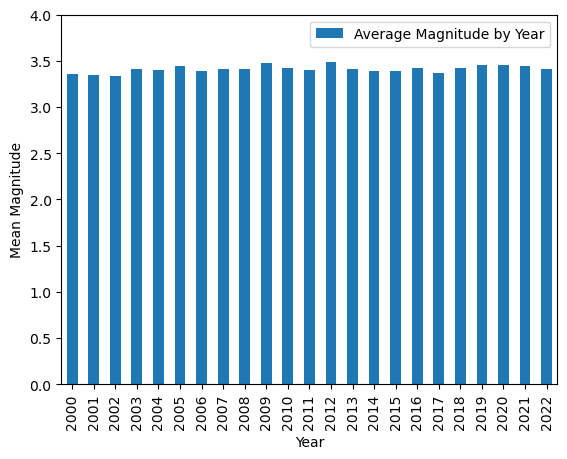

In [49]:
# Plot the mean magnitude by magnitude type
df_mag_year.plot(kind="bar")

# Label x and y axis
plt.xlabel("Year")
plt.ylabel("Mean Magnitude")
plt.yticks([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
plt.legend(["Average Magnitude by Year"])

# Show the plot
plt.show()

In [50]:
df_mag_count = pd.DataFrame(df_converted_mag_by_year.groupby(["year"])["mag"].count())
df_mag_count

,mag
year,
2000,318
2001,311
2002,197
2003,408
2004,364
2005,261
2006,197
2007,196
2008,201


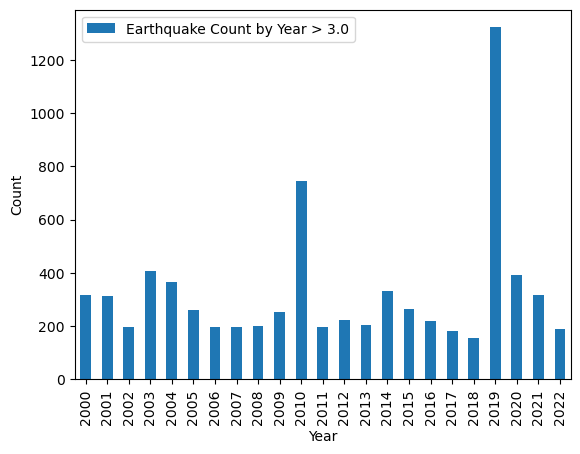

In [51]:
# Plot the count of magnitude 3.0 tremor by year
df_mag_count.plot(kind="bar")

# Label x and y axis
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(["Earthquake Count by Year > 3.0"])

# Show the plot
plt.show()

In [52]:
# Close the database
conn.close()